## Importing necessary modules and processing the data

In [2]:
from autograd import grad, hessian
import autograd.scipy.stats as st
from scipy.stats import levy_stable, norm, multivariate_normal
import autograd.numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from datetime import datetime, timedelta

sheet_url = "https://docs.google.com/spreadsheets/d/1BLTbmVfB-tACJULIw4EW6c4dHA48C7SX6T6W9GB5ZSg/edit#gid=0"
csv_export_url = sheet_url.replace('/edit#gid=', '/export?format=csv&gid=')
df = pd.read_csv(csv_export_url)

date_column = "Date"
input_column = "CumulativeScientists"
output_column = "TFP"

start_date = datetime.strptime("1948-01-01", "%Y-%m-%d")
end_date = datetime.strptime("2014-01-01", "%Y-%m-%d")

In [3]:
import re

input_pairs = []
output_pairs = []

input_dict = dict()
output_dict = dict()

date_inputs = []

for index, row in df.iterrows():
   datetime_object = datetime.strptime(row["Date"], "%Y-%m-%d")
   if start_date > datetime_object:
     continue
   elif end_date < datetime_object:
     break
   else:
     if pd.notnull(df.at[index, input_column]):
        input_pairs.append((datetime_object, float(row[input_column])))
        input_dict[datetime_object] = float(row[input_column])

     if pd.notnull(df.at[index, output_column]):
        output_pairs.append((datetime_object, float(row[output_column])))
        output_dict[datetime_object] = float(row[output_column])

date_inputs = sorted([date for date in input_dict])
log_output_pairs = [(x[0], np.log(x[1])) for x in output_pairs]

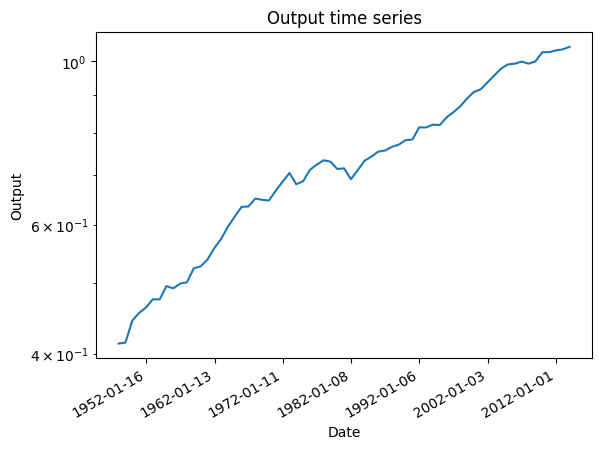

In [4]:
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=3650))
plt.plot([pair[0] for pair in output_pairs],[pair[1] for pair in output_pairs])
plt.gcf().autofmt_xdate()

plt.yscale("log")
plt.ylabel("Output")
plt.xlabel("Date")
plt.title("Output time series")

plt.savefig("output.pdf")
plt.show()

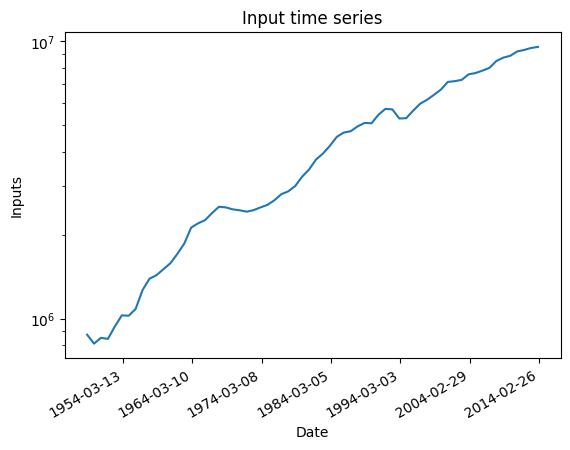

In [5]:
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=3650))

cumulative_inputs = np.array([pair[1] for pair in input_pairs])
plt.plot([pair[0] for pair in input_pairs][1:], cumulative_inputs[1:] - cumulative_inputs[:-1])
plt.gcf().autofmt_xdate()

plt.yscale("log")
plt.ylabel("Inputs")
plt.xlabel("Date")
plt.title("Input time series")

plt.savefig("input.pdf")
plt.show()

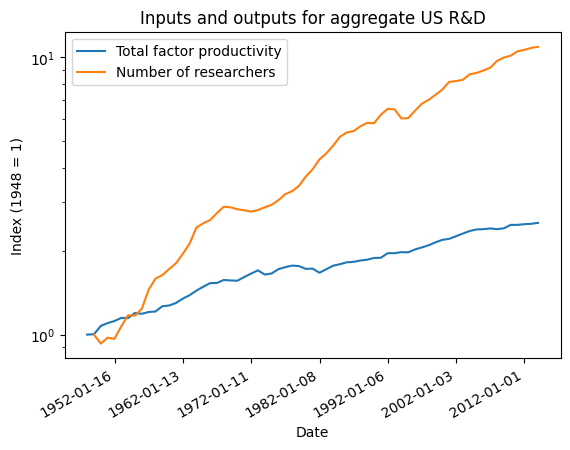

In [6]:
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=3650))
plt.plot([pair[0] for pair in output_pairs],[pair[1]/output_pairs[0][1] for pair in output_pairs], label="Total factor productivity")
plt.plot([pair[0] for pair in input_pairs][1:], (cumulative_inputs[1:] - cumulative_inputs[:-1])/(cumulative_inputs[1] - cumulative_inputs[0]) \
                                              , label="Number of researchers")
plt.gcf().autofmt_xdate()

plt.yscale("log")
plt.ylabel("Index (1948 = 1)")
plt.xlabel("Date")
plt.title("Inputs and outputs for aggregate US R&D")
plt.legend()

plt.savefig("input_output.pdf")
plt.show()

## Correlation coefficient between inputs and outputs

In [7]:
np.corrcoef(cumulative_inputs[1:] - cumulative_inputs[:-1], [pair[1] for pair in output_pairs][:-1])[0, 1]

0.9738472555840157

## Defining the negative log likelihood function

In [8]:
import bisect

def linear_interpolation(date_to_interpolate, date_value_pairs):
    # Make sure list is sorted by datetime
    date_value_pairs = sorted(date_value_pairs, key=lambda x: x[0])

    for i in range(len(date_value_pairs) - 1):
        current_date, current_value = date_value_pairs[i]
        next_date, next_value = date_value_pairs[i + 1]

        if current_date <= date_to_interpolate <= next_date:
            total_seconds = (next_date - current_date).total_seconds()
            elapsed_seconds = (date_to_interpolate - current_date).total_seconds()

            # Compute interpolated value
            interpolated_value = current_value + (next_value - current_value) * (elapsed_seconds / total_seconds)
            return interpolated_value

    return None  # The date_to_interpolate was not in the range of dates in the list

def compute_integral(t1, t2, date_value_pairs_local, lambda_val=1, dates=None):
  date_value_pairs_local = sorted(date_value_pairs_local, key=lambda x: x[0])
  prev_date = None
  integral = 0

  init_index = 0
  #if dates != None:
     #init_index = max(bisect.bisect_left(dates, t1) - 1, 0)

  for i in range(init_index, len(date_value_pairs_local) - 1):
      (current_date, current_value) = date_value_pairs_local[i]
      (next_date, next_value) = date_value_pairs_local[i + 1]

      if current_date <= t1 <= next_date and current_date <= t2 <= next_date:
          total_seconds = (next_date - current_date).total_seconds()
          elapsed_seconds = (t2 - t1).total_seconds()

          integral += elapsed_seconds * ((next_value - current_value)/total_seconds)**lambda_val
          break
      elif t1 <= current_date and t2 >= next_date:
          total_seconds = (next_date - current_date).total_seconds()
          integral += total_seconds * ((next_value - current_value)/total_seconds)**lambda_val
      elif t2 >= current_date and t2 <= next_date:
          total_seconds = (next_date - current_date).total_seconds()
          elapsed_seconds = (t2 - current_date).total_seconds()

          integral += elapsed_seconds * ((next_value - current_value)/total_seconds)**lambda_val
          break
      elif t1 <= next_date and t1 >= current_date:
          total_seconds = (next_date - current_date).total_seconds()
          elapsed_seconds = (next_date - t1).total_seconds()

          integral += elapsed_seconds * ((next_value - current_value)/total_seconds)**lambda_val
      else:
          continue

  return integral

def norm_logpdf(x, mu=0, sigma=1):
    n = len(x)
    return -np.sum(np.log(sigma)) - n * np.log(2*np.pi)/2 - (1/2) * np.sum(((x - mu)/sigma)**2)

def norm_logpdf_scalar(x, mu=0, sigma=1):
    return -np.log(sigma) - np.log(2*np.pi)/2 - (1/2) * ((x - mu)/sigma)**2

def sigmoid(x):
    return 1/(1 + np.exp(-x))

In [9]:
np.seterr(all='raise')
likelihood_divisor = 1000

def custom_cdf(x, phi, shift, loc, scale):
  return st.norm.cdf(x**phi - shift**phi, loc=loc, scale=scale)

custom_pdf = grad(custom_cdf)

def custom_logpdf_t(x, phi, shift, loc, scale, df):
  return np.log(phi) + (phi-1)*np.log(x) + st.t.logpdf(x**phi - shift**phi, df, loc, scale)

def custom_logpdf(x, phi, shift, loc, scale):
  return np.log(phi) + (phi-1)*np.log(x) + norm_logpdf_scalar(x**phi, loc + shift**phi, scale)

def custom_logpdf_levy(x, phi, loc, scale, alpha, beta):
  if alpha == 2:
    #print(phi, loc, scale, alpha, beta)
    return np.log(np.abs(phi)) + (phi-1)*np.log(x) + norm_logpdf_scalar(x**phi, loc, scale)
  else:
    return np.log(np.abs(phi)) + (phi-1)*np.log(x) + levy_stable.logpdf(x**phi, alpha, beta, loc = loc, scale = scale)

def parameter_transform(params):
   phi, lambda_val = params[:2]
   delta, sigma = np.exp(params[2:4])
   alpha = 1 + sigmoid(params[4])
   beta = 2 * sigmoid(params[5]) - 1

   return phi, lambda_val, delta, sigma, alpha, beta

def negative_log_likelihood(params, output_pair_indices):
  global output_pairs

  phi, lambda_val = params[:2]
  delta, sigma = np.exp(params[2:4])
  alpha = 1 + sigmoid(params[4])
  beta = 2 * sigmoid(params[5]) - 1
  #lambda_val = 0
  alpha = 2
  noise_exponent = phi - phi/alpha

  result = 0

  for i in output_pair_indices:
      (current_date, current_value) = output_pairs[i]
      (next_date, next_value) = output_pairs[i+1]

      if current_date == next_date:
         continue

      if next_date > input_pairs[-1][0]:
         break

      current_input_eq = current_value
      next_input_eq = next_value

      time_elapsed = (next_date - current_date).total_seconds()

      integral = compute_integral(current_date, next_date, input_pairs.copy(), lambda_val, date_inputs)
      #print(current_date, next_date, integral)
      result -= custom_logpdf_levy(next_input_eq, phi, current_input_eq**phi + delta*phi*integral, sigma * current_input_eq**noise_exponent * integral**(1/alpha), alpha, beta)

  return result/likelihood_divisor

## Fitting the model and displaying the results

In [10]:
from scipy.optimize import minimize
#levy_stable.pdf_default_method = "piecewise"

Nfeval = 1
fun_last = None
x0 = [1, 1, -18, -10, 1, 1]
#x0 = [  2.14726355,   0.93654581, -18.78601344,   1.99703848,
#       -11.34065512,   7.35683492,   1.09148744]
#x0 = np.array([  1.37006975,  -0.17932827, -21.09953669, -12.37585873,
#         1.54337566, -12.55231435])


def callbackF(Xi):
    global Nfeval, fun_last
    fun = negative_log_likelihood(Xi, range(len(output_pairs)-1))

    if fun != fun_last:
      Xf = parameter_transform(Xi.copy())
      print('{0:4d}   {1: 3.6f}   {2: 3.6f}   {3: 3.6f}   {4: 3.6f}   {5: 3.6f}   {6: 3.6f}   log likelihood: {7: 3.6f}'.format(Nfeval, Xf[0], Xf[1], Xf[2], Xf[3], \
                                                                                                                                            Xf[4], Xf[5], -likelihood_divisor*fun))
      Nfeval += 1
      fun_last = fun

res = minimize(negative_log_likelihood, x0=x0, args=(range(len(output_pairs)-1)), \
               callback=callbackF, method="BFGS", options={"gtol": 1e-6})
print(res)

   1    1.108378    1.523119    0.000000    0.000038    1.731059    0.462117   log likelihood:  151.511041
   2    1.138255    1.618306    0.000000    0.000036    1.731059    0.462117   log likelihood:  154.344323
   3    1.158393    1.620103    0.000000    0.000036    1.731059    0.462117   log likelihood:  154.846900
   4    1.351444    1.562615    0.000000    0.000032    1.731059    0.462117   log likelihood:  158.754989
   5    1.693289    1.403561    0.000000    0.000026    1.731059    0.462117   log likelihood:  162.117834
   6    1.691840    1.410264    0.000000    0.000027    1.731059    0.462117   log likelihood:  163.662313
   7    2.069050    1.307569    0.000000    0.000026    1.731059    0.462117   log likelihood:  177.067821
   8    3.093737    1.020437    0.000000    0.000022    1.731059    0.462117   log likelihood:  195.591654
   9    3.819280    0.836834    0.000000    0.000018    1.731059    0.462117   log likelihood:  200.695042
  10    4.046552    0.793521    0.000

In [11]:
res.x

array([  5.4184194 ,   1.32713917, -20.46673414, -10.49585091,
         1.        ,   1.        ])

In [12]:
res.hess_inv

array([[6.05129265e+03, 2.03775074e+03, 2.47727365e+03, 2.44055440e+03,
        0.00000000e+00, 0.00000000e+00],
       [2.03775074e+03, 7.09600147e+02, 8.93462729e+02, 8.48659050e+02,
        0.00000000e+00, 0.00000000e+00],
       [2.47727365e+03, 8.93462729e+02, 1.18520835e+03, 1.06707180e+03,
        0.00000000e+00, 0.00000000e+00],
       [2.44055440e+03, 8.48659050e+02, 1.06707180e+03, 1.02299994e+03,
        0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 1.00000000e+00]])

In [13]:
from scipy.stats import chi2
print(chi2.sf(2*(203.421946 - 202.266945), 1))

0.128543884622492


The fitted parameter values as a six-tuple: beta, lambda, theta, sigma, alpha_levy and beta_levy.

In [14]:
print(parameter_transform(res.x))

(5.418419401083313, 1.3271391692483505, 1.2924397316704445e-09, 2.7650937805475903e-05, 1.7310585786300048, 0.4621171572600098)


Standard errors for the *untransformed* parameters. These are in linear space for the first two parameters, in log space for the first four parameters, and in inverse sigmoid space for the last two.

In [15]:
cov_matrix = res.hess_inv/likelihood_divisor
standard_errors = np.sqrt(np.diagonal(cov_matrix))
print(standard_errors)

[2.45993753 0.84237767 1.08867275 1.0114346  0.03162278 0.03162278]


Calculate the two sigma confidence intervals in untransformed space and transform them to linear space.

In [16]:
print(parameter_transform(res.x))
print(parameter_transform(res.x - 2*standard_errors))
print(parameter_transform(res.x + 2*standard_errors))

(5.418419401083313, 1.3271391692483505, 1.2924397316704445e-09, 2.7650937805475903e-05, 1.7310585786300048, 0.4621171572600098)
(0.49854433979133983, -0.35761618057485056, 1.4648770189387653e-10, 3.657538754574226e-06, 1.7184436048503617, 0.4368872097007235)
(10.338294462375288, 3.011894519071552, 1.140300815976004e-08, 0.00020904067265619462, 1.7433102860443912, 0.4866205720887824)


Compute a point estimate, standard error, and confidence interval for log(returns to research effort).

In [17]:
r_log_std = np.sqrt((res.hess_inv[0, 0] + res.hess_inv[1, 1] - 2*res.hess_inv[0, 1])/likelihood_divisor)
r_log = res.x[1] - res.x[0]

print("Log returns to research effort: %.3f" % (r_log))
print("Log standard error of the returns to research effort: %.3f" % (r_log_std))
print("Returns to research effort, one sigma confidence interval: %.3f, %.3f, %.3f" % (np.exp(r_log - r_log_std), np.exp(r_log), np.exp(r_log + r_log_std)))

Log returns to research effort: -4.091
Log standard error of the returns to research effort: 1.639
Returns to research effort, one sigma confidence interval: 0.003, 0.017, 0.086


In [18]:
bootstrap_samples = 10000
phi_lambda_samples = multivariate_normal.rvs(mean=res.x[:2], cov=cov_matrix[:2, :2], size=bootstrap_samples)
r_samples = [s[1]/s[0] for s in phi_lambda_samples]

print("Median: \t%.3f" % (np.median(r_samples)))
print("5th pct: \t%.3f" % (np.percentile(r_samples, 5)))
print("95th pct: \t%.3f" % (np.percentile(r_samples, 95)))

Median: 	0.247
5th pct: 	0.019
95th pct: 	0.303


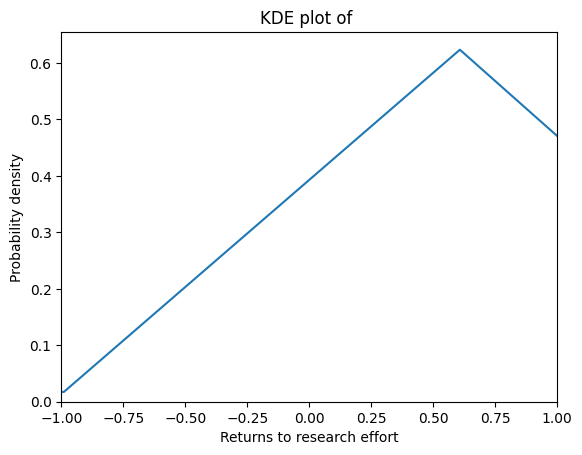

In [21]:
fig, ax = plt.subplots()

sns.kdeplot(r_samples, ax=ax)
ax.set_xlim(-1, 1)

plt.xlabel("Returns to research effort")
plt.ylabel("Probability density")
plt.title("KDE plot of ")
plt.show()

In [22]:
from scipy.stats import norm

np.exp(r_log + norm.isf(0.05)*r_log_std)

0.2476270041879146

In [23]:
from scipy.stats import norm

print("%.2e" % (1 - norm.sf(0, loc=res.x[1], scale=standard_errors[1])))

5.76e-02


In [ ]:
print(res.x)

[  5.41844158   1.32714614 -20.46672639 -10.49584281   1.
   1.        ]


Compute standard errors in linear space using the exact Hessian.

In [20]:
hess_negative_log_likelihood = hessian(lambda x: negative_log_likelihood(np.array([x[0], x[1], np.log(x[2]), np.log(x[3]), 0, 0]), range(len(output_pairs)-1)))
hessian_matrix = hess_negative_log_likelihood(np.array(parameter_transform(res.x)))
inv_hessian_matrix = np.linalg.inv(hessian_matrix[:4, :4])

standard_errors = np.sqrt(np.diagonal(inv_hessian_matrix)/likelihood_divisor)
print(standard_errors)

[2.55072625e+00 8.72368002e-01 1.44982051e-09 2.87414973e-05]


In [24]:
def plot_results(phi, lambda_val, delta):
  #noise_exponent = 1
  #lambda_val = 0

  x = []
  y = []
  cumulative_effort = 0

  for i in range(len(input_pairs) - 1):
      (current_date, current_compute) = input_pairs[i]
      (next_date, next_compute) = input_pairs[i + 1]

      if current_date == next_date:
         continue

      total_seconds = (next_date - current_date).total_seconds()
      integral = total_seconds * ((next_compute - current_compute)/total_seconds)**lambda_val
      cumulative_effort += integral

      current_compute_eq = linear_interpolation(current_date, output_pairs)
      #print(next_date)
      next_compute_eq = linear_interpolation(next_date, output_pairs)

      x.append((delta*phi*cumulative_effort + output_pairs[0][1]**phi)**(1/phi))
      y.append(next_compute_eq)

  plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
  plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=3650))
  plt.plot([pair[0] for pair in output_pairs],[pair[1] for pair in output_pairs])
  plt.plot([pair[0] for pair in input_pairs], np.array([output_pairs[0][1]] + x), color="red")

  plt.gcf().autofmt_xdate()

  plt.yscale("log")
  plt.ylabel("Output")
  plt.xlabel("Date")
  plt.title("Output time series - predicted vs actual")

  plt.savefig("comparison_with_fitted_model.pdf")
  plt.show()

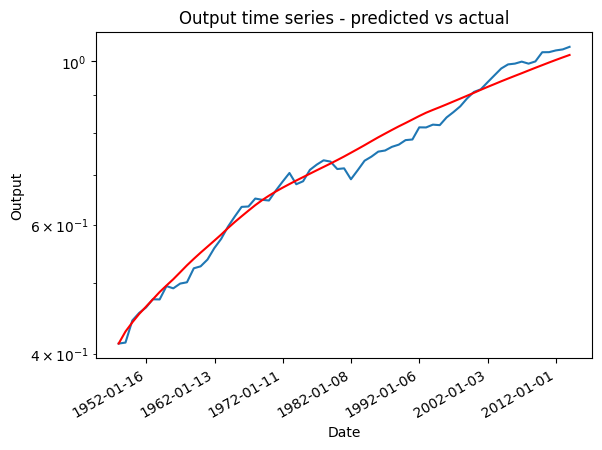

In [25]:
plot_results(*parameter_transform(res.x)[:3])

## Simulation results

In [26]:
def simulate_levy_distribution(params, initial_date, final_date, time_delta_days=365):
   phi, lambda_val, delta, sigma, alpha, beta = parameter_transform(params)
   alpha = 2

   noise_exponent = phi - phi/alpha

   date = initial_date
   alg_progress = np.exp(linear_interpolation(initial_date, log_output_pairs))
   alg_list = [alg_progress]
   date_list = [date]

   while date < final_date:
     next_date = date + timedelta(days=time_delta_days)
     integral = compute_integral(date, next_date, input_pairs, lambda_val, date_inputs)
     if alpha == 2:
       epsilon = norm.rvs(loc=0, scale=1)
     else:
       epsilon = levy_stable.rvs(alpha, beta)

     alg_progress = (alg_progress**phi + delta*phi*integral \
                     + sigma * integral**(1/alpha) * alg_progress**noise_exponent * epsilon)**(1/phi)
     alg_list.append(alg_progress)
     date_list.append(next_date)

     date = next_date

   return date_list, alg_list

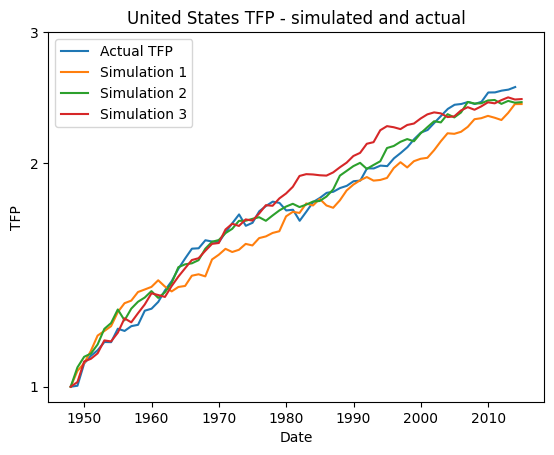

In [34]:
actual_tfp_dates = [pair[0] for pair in output_pairs]
normalized_tfp_values = np.array([pair[1] for pair in output_pairs])
normalized_tfp_values /= min(normalized_tfp_values)

plt.plot(actual_tfp_dates,normalized_tfp_values, label="Actual TFP")

np.random.seed(42)

for i in range(3):
   x, y = simulate_levy_distribution(res.x, start_date, end_date)
   plt.plot(x, y/min(y), label=("Simulation %d" % (i+1)))

# Set y-axis to use a logarithmic scale
plt.yscale('log')

# Manually set y-axis tick labels without scientific notation
yticks = [1, 2, 3]  # Define the desired tick positions
yticklabels = ['1', '2', '3']  # Corresponding labels
plt.yticks(yticks, yticklabels)

# Labels for y-axis, x-axis, and title
plt.ylabel("TFP")
plt.xlabel("Date")
plt.title("United States TFP - simulated and actual")

# Add a legend
plt.legend()

# Show the plot
plt.savefig("simulated-actual-tfp.pdf")
plt.show()

## Bootstrapping

In [28]:
np.random.seed(42)

num_bootstrap = 100
sampled_params = []
x0 = [1, 1, -18, -10, 1, 1]

for i in range(num_bootstrap):
   random_indices = np.random.randint(0, len(output_pairs)-1, size=len(output_pairs)-1)

   res = minimize(negative_log_likelihood, x0=x0, args=(random_indices), \
                 method="BFGS", options={"gtol": 1e-6})
   sampled_params.append(res.x)

   if i % 10 == 9:
     print("%dth bootstrap complete!" % (i+1))

10th bootstrap complete!
20th bootstrap complete!
30th bootstrap complete!
40th bootstrap complete!
50th bootstrap complete!
60th bootstrap complete!
70th bootstrap complete!
80th bootstrap complete!
90th bootstrap complete!
100th bootstrap complete!


In [29]:
phi_vals = [pi[0] for pi in sampled_params]
lambda_vals = [pi[1] for pi in sampled_params]
r_vals = [pi[1]/pi[0] for pi in sampled_params]
r_vals_pos_lambda = [r_vals[i] for i in range(len(r_vals)) if lambda_vals[i] > 0]

print("Beta: \t\t%.3f (%.3f)" % (np.median(phi_vals), np.std(phi_vals)))
print("Lambda: \t%.3f (%.3f)" % (np.median(lambda_vals), np.std(lambda_vals)))
print("Returns: \t%.3f (%.3f)" % (np.median(r_vals), np.std(r_vals)))
print("Returns (lambda > 0): \t%.3f (%.3f)" % (np.median(r_vals_pos_lambda), np.std(r_vals_pos_lambda)))

Beta: 		5.247 (2.510)
Lambda: 	1.263 (0.821)
Returns: 	0.247 (17.400)
Returns (lambda > 0): 	0.251 (0.056)


In [ ]:
len([x for x in lambda_vals if x < 0])

6

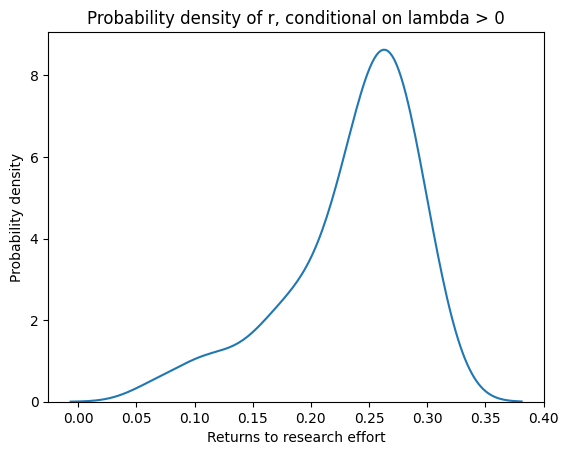

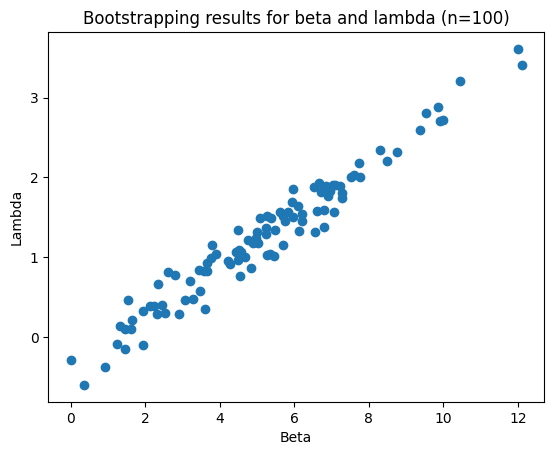

In [ ]:
fig, ax = plt.subplots()
sns.kdeplot([r_vals[i] for i in range(len(r_vals)) if lambda_vals[i] > 0], ax=ax)

plt.xlabel("Returns to research effort")
plt.ylabel("Probability density")

plt.title("Probability density of r, conditional on lambda > 0")

plt.savefig("returns_density_tfp.pdf")
plt.show()

plt.scatter(phi_vals, lambda_vals)
plt.xlabel("Beta")
plt.ylabel("Lambda")
plt.title("Bootstrapping results for beta and lambda (n=%d)" % (num_bootstrap))

plt.savefig("bootstrap_tfp.pdf")
plt.show()

## Linear regression

In [ ]:
import statsmodels.api as sm

endog = np.array([np.log((log_output_pairs[i+10][1] - log_output_pairs[i][1]) \
                         /(log_output_pairs[i+10][0] - log_output_pairs[i][0]).total_seconds()) for i in range(len(output_pairs) - 10)])
exog = np.stack(([log_output_pairs[i][1] for i in range(len(log_output_pairs) - 10)], \
                  [np.log(compute_integral(log_output_pairs[i][0], log_output_pairs[i+10][0], input_pairs, lambda_val=1) \
                          /(log_output_pairs[i+10][0] - log_output_pairs[i][0]).total_seconds()) \
                   for i in range(len(log_output_pairs) - 10)], \
                 [(log_output_pairs[i][0] - log_output_pairs[0][0]).total_seconds()/(timedelta(days=365).total_seconds()) \
                  for i in range(len(output_pairs) - 10)]))

np.shape(endog)
model = sm.OLS(endog=endog, exog=sm.add_constant(np.transpose(exog))[:, :3])
res = model.fit(cov_type='HAC', cov_kwds={"maxlags": 1})
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.526
Model:                            OLS   Adj. R-squared:                  0.509
Method:                 Least Squares   F-statistic:                     24.00
Date:                Thu, 07 Sep 2023   Prob (F-statistic):           3.48e-08
Time:                        12:05:29   Log-Likelihood:                -36.762
No. Observations:                  57   AIC:                             79.52
Df Residuals:                      54   BIC:                             85.65
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -18.3119      1.166    -15.700      0.0